<a href="https://colab.research.google.com/github/Anikate-De/DermaDoc-DL/blob/main/DermaDoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create & Train Model

### Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets download ismailpromus/skin-diseases-image-dataset

### Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset ZIP -> Drive

In [3]:
!cp "/content/skin-diseases-image-dataset.zip" "/content/drive/MyDrive/Colab Notebooks/DermaDoc/data"

cp: cannot stat '/content/skin-diseases-image-dataset.zip': No such file or directory


### Drive -> Dataset ZIP

In [5]:
!cp "/content/drive/MyDrive/Colab Notebooks/DermaDoc/data/skin-diseases-image-dataset.zip" "/content/skin-diseases-image-dataset.zip"

### Unzip and split

In [14]:
import zipfile

# Unzip the downloaded data
zip = zipfile.ZipFile('skin-diseases-image-dataset.zip')
zip.extractall()
zip.close()

In [12]:
!pip install split-folders

In [7]:
!mkdir split

In [15]:
import splitfolders # "split" folder on your own

splitfolders.ratio('IMG_CLASSES/',output='split',seed=42,ratio=(.8,.2),group_prefix=None)

Copying files: 27153 files [01:19, 341.45 files/s] 


In [18]:
!rm -rf IMG_CLASSES

In [19]:
# Get the class names programmatically
import pathlib
import numpy as np
data_directory = pathlib.Path('split/train')
class_names = np.array(sorted(item.name for item in data_directory.glob('*')))
print(class_names)

['1. Eczema 1677' '10. Warts Molluscum and other Viral Infections - 2103'
 '2. Melanoma 15.75k' '3. Atopic Dermatitis - 1.25k'
 '4. Basal Cell Carcinoma (BCC) 3323' '5. Melanocytic Nevi (NV) - 7970'
 '6. Benign Keratosis-like Lesions (BKL) 2624'
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k'
 '8. Seborrheic Keratoses and other Benign Tumors - 1.8k'
 '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


### Necessary Libraries

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Create Directory Flows

In [17]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Import data and turn it into batches
training_set = train_datagen.flow_from_directory('split/train',
                                               batch_size = 16,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                               seed = 42)
validation_set = test_datagen.flow_from_directory('split/val',
                                               batch_size = 16,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                               seed = 42)


Found 21719 images belonging to 10 classes.
Found 5434 images belonging to 10 classes.


### Drive -> Model (.pb)
### Load Model

In [22]:
!mkdir -p '/content/trained_for_2_epochs/effb7'
!cp -R "/content/drive/MyDrive/Colab Notebooks/DermaDoc/models/trained_for_2_epochs/effb7/" '/content/trained_for_2_epochs/effb7'

In [24]:
efficientnet_b7_model = tf.keras.saving.load_model('trained_for_2_epochs/effb7')

### Create Model

In [ ]:
efficientnet_b7_model = Sequential()

efficientnet_b7_model.add(EfficientNetB7(include_top=False,
                                         weights='imagenet',
                                         classes=10,
                                         input_shape=(224,224,3),
                                         pooling='max'))

efficientnet_b7_model.add(Dropout(0.5))

efficientnet_b7_model.add(Dense(10, activation='softmax'))

efficientnet_b7_model.compile(loss="categorical_crossentropy",
                optimizer=Adam(0.0001,weight_decay=0.01),
                metrics=["accuracy", "AUC"])

### Train Model

In [ ]:
efficientnet_b7_history = efficientnet_b7_model.fit(training_set,
                                                    epochs=2,
                                                    steps_per_epoch=len(training_set),
                                                    validation_data=validation_set,
                                                    validation_steps=len(validation_set),)

Epoch 1/2
1358/1358 [==============================] - 1384s 896ms/step - loss: 1.2326 - accuracy: 0.6029 - auc: 0.9207 - val_loss: 0.7754 - val_accuracy: 0.7137 - val_auc: 0.9677
Epoch 2/2
1358/1358 [==============================] - 1216s 895ms/step - loss: 0.6530 - accuracy: 0.7614 - auc: 0.9754 - val_loss: 0.7472 - val_accuracy: 0.7262 - val_auc: 0.9683


### Auxiliary: Plot Curves from History

In [ ]:
import pandas as pd

def plot_curves(history, loss_function):
  """

    Plots Curves using model training history.

    Params:
      (tensorflow.keras.callbacks.History) history: The History object that is obtained upon fitting the model.
      (str) loss_function: The Loss Function that has been used to calculate the loss of the model.

    Returns:
      None

    Output:
      A matplotlib.pyplot figure of <num_images> images.

  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  auc = history.history['auc']
  val_auc = history.history['val_auc']

  pd.DataFrame({'Loss': loss, 'Validation Loss': val_loss}).plot(title = 'Loss Curves', xlabel = 'Epoch', ylabel = loss_function)
  pd.DataFrame({'Accuracy': accuracy, 'Validation Accuracy': val_accuracy}).plot(title = 'Accuracy Curves', xlabel = 'Epoch', ylabel = 'Accuracy')
  pd.DataFrame({'AUC': auc, 'Validation AUC': val_auc}).plot(title = 'AUC Curves', xlabel = 'Epoch', ylabel = 'AUC')

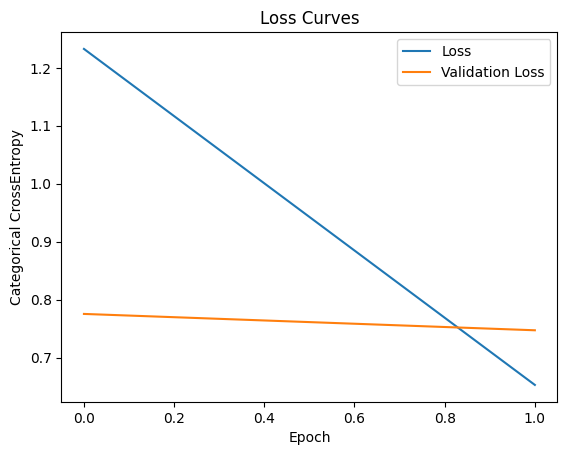

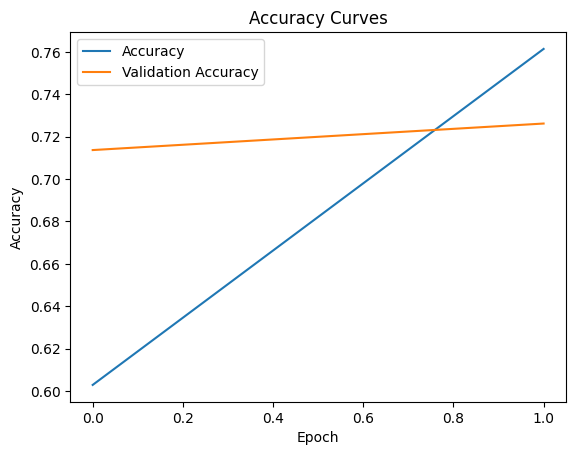

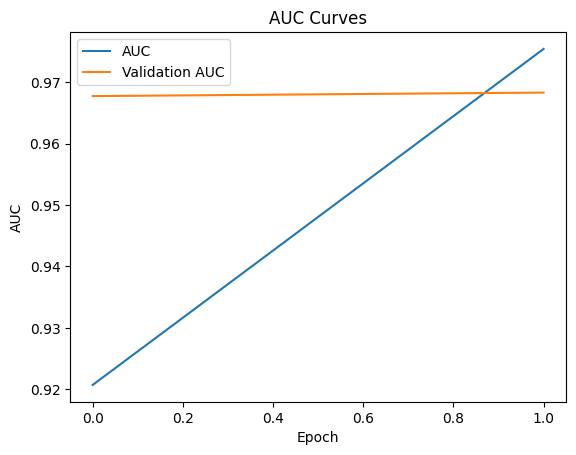

In [ ]:
plot_curves(efficientnet_b7_history, 'Categorical CrossEntropy')

### Auxiliary: Predict Random Images

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import random
import os

# Predict random images
def predict_random_images_multiclass(target_dir, model, class_names, num_images = 1, target_classes = None):

  if (num_images > 10):
    print('A maximum of 10 images is allowed')
    num_images = 10

  if target_classes == None:
    target_classes = class_names

  plt.figure(figsize = (18, 8))

  for i in range(num_images):
    random_class = random.choice(target_classes)
    target_path = target_dir + random_class
    img = mpimp.imread(target_path + '/' + random.choice(os.listdir(path = target_path)))
    img = tf.image.resize(img, size = [224, 224])
    img /= 255

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)


    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0), verbose = 0)

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    if pred_class == random_class:
      color = 'green'
    else:
      color = 'red'

    plt.title(f'Prediction: {pred_class.title()}\nTrue: {random_class.title()}\nConfidence: {(tf.reduce_max(pred) * 100):.2f}%', fontdict = {'color' : color})
    plt.axis('off')

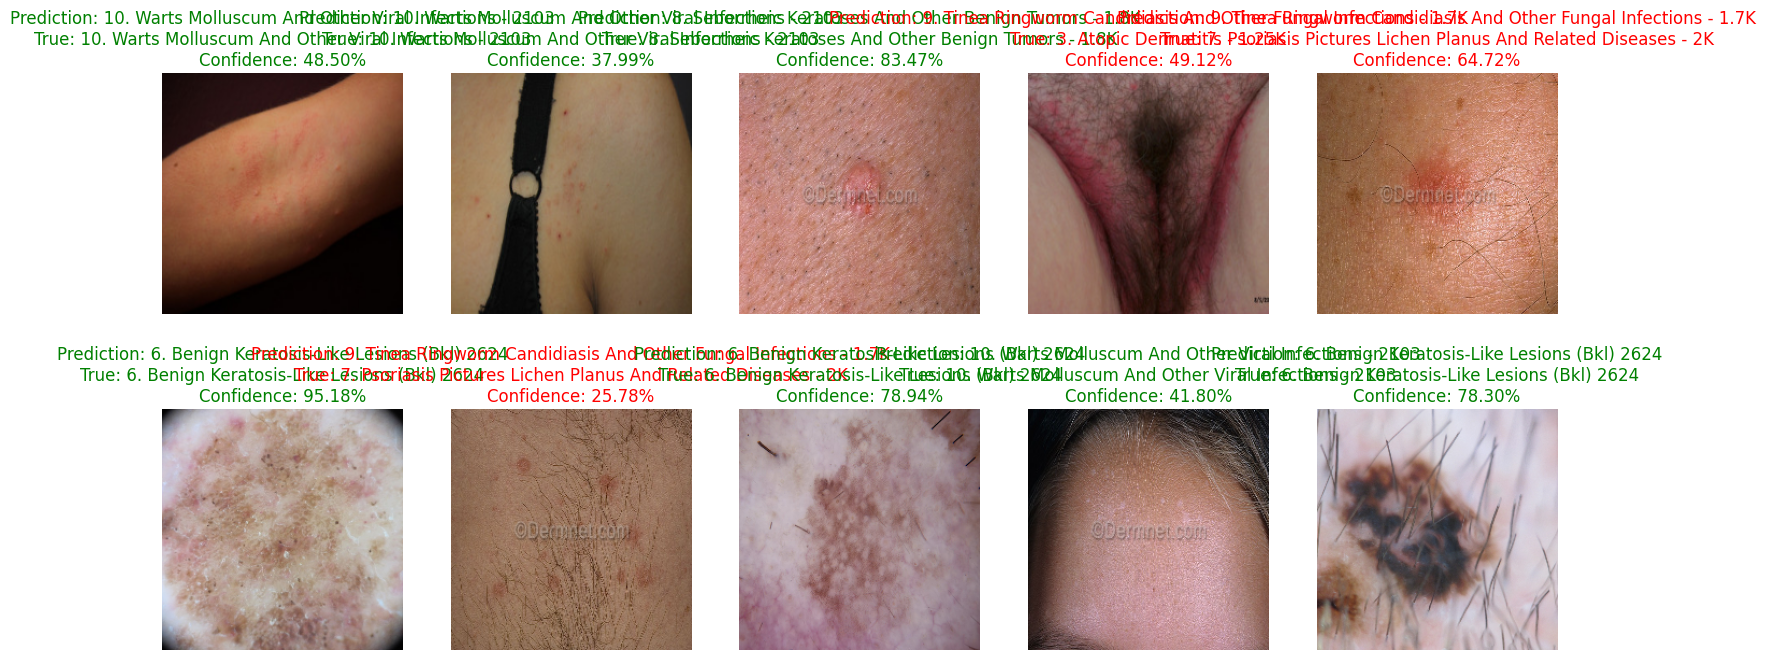

In [26]:
predict_random_images_multiclass(target_dir = 'split/train/', model = efficientnet_b7_model, class_names = class_names, num_images = 10)

### Evaluate

In [ ]:
efficientnet_b7_model.evaluate(validation_set)

### Save Model (.h5, .pb)

In [ ]:
efficientnet_b7_model.save('trained_for_2_epochs/effb7.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
efficientnet_b7_model.save('trained_for_2_epochs/effb7')

### .H5 -> Drive

In [ ]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/DermaDoc/models/trained_for_2_epochs/"
!cp '/content/trained_for_2_epochs/effb7.h5' "/content/drive/MyDrive/Colab Notebooks/DermaDoc/models/trained_for_2_epochs/effb7.h5"

### PB -> Drive

In [ ]:
!cp -R '/content/trained_for_2_epochs/effb7' "/content/drive/MyDrive/Colab Notebooks/DermaDoc/models/trained_for_2_epochs/effb7"

### Predict Given Image

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import random
import os
import numpy as np
from PIL import Image
import urllib
import json
import time
from io import BytesIO


def predict_network_img(model, class_names, url):
  '''
    Predict an image from the network
  '''
  start_time = time.time()

  im = Image.open(urllib.request.urlopen(url))
  return predict_img(model, class_names, im, start_time)

def predict_img_bytes(model, class_names, bytes):
  '''
    Predict an image from a bytestream
  '''
  start_time = time.time()

  im = Image.open(BytesIO(bytes))
  return predict_img(model, class_names, im, start_time)


def predict_img(model, class_names, im, start_time):
  lower_bound = min(im.size)
  img = np.array(im.crop((0, 0, lower_bound, lower_bound)))
  img = tf.image.resize(img, size = [224, 224])
  img /= 255

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0), verbose = False)

  full_class_names = class_names
  class_names = list(map(lambda x: x[:16].strip()+"...", class_names))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  plt.figure(figsize = (12, 12))

  plt.subplot(1, 2, 1)
  plt.title(f'Prediction: {pred_class.title()}\nConfidence: {(tf.reduce_max(pred) * 100):.2f}%')
  plt.axis('off')
  plt.imshow(img)

  plt.subplot(1, 4, 4)
  plt.axis('on')
  plt.pie(np.squeeze(pred)*100,
          labels = class_names,
          autopct='%1.1f%%',
          textprops={'size': 'x-large',
                     'fontweight': 'light'},
          radius=2.2)
  plt.show()

  return {
            'datetime': int(time.time() * 1000),
            'consumed_time': int((time.time() - start_time) * 1000),
            'prediction': full_class_names[pred.argmax()],
            'confidence': round(float((tf.reduce_max(pred) * 100).numpy()),2)
          }

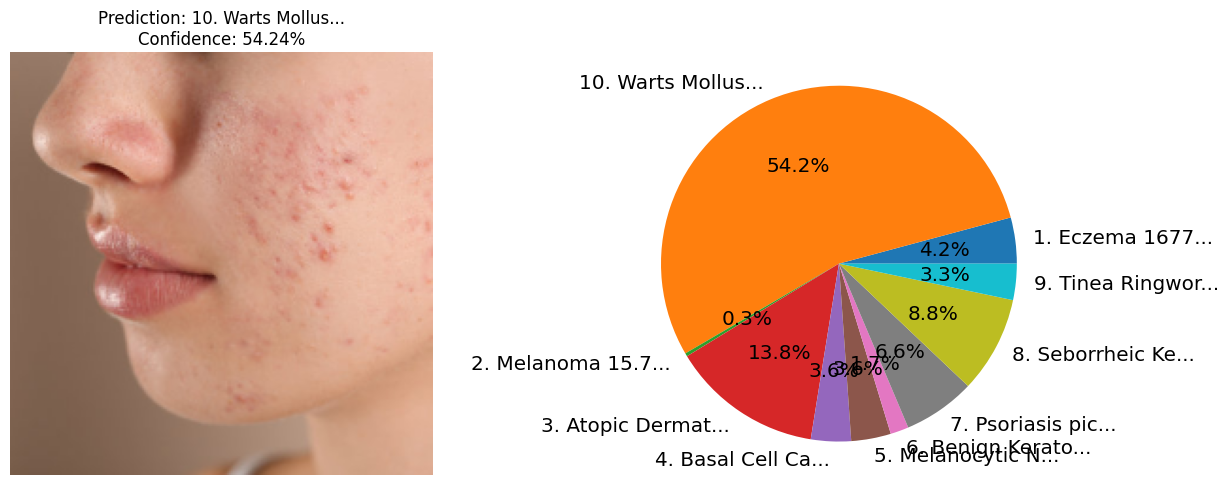

{'datetime': 1695686295637,
 'consumed_time': 2770,
 'prediction': '10. Warts Molluscum and other Viral Infections - 2103',
 'confidence': 54.24}

In [39]:
predict_network_img(efficientnet_b7_model, class_names, "https://t3.ftcdn.net/jpg/03/08/58/40/360_F_308584000_y1HR0WQBLgjD9FXzMW8HUqb5u1wxeLgS.jpg")

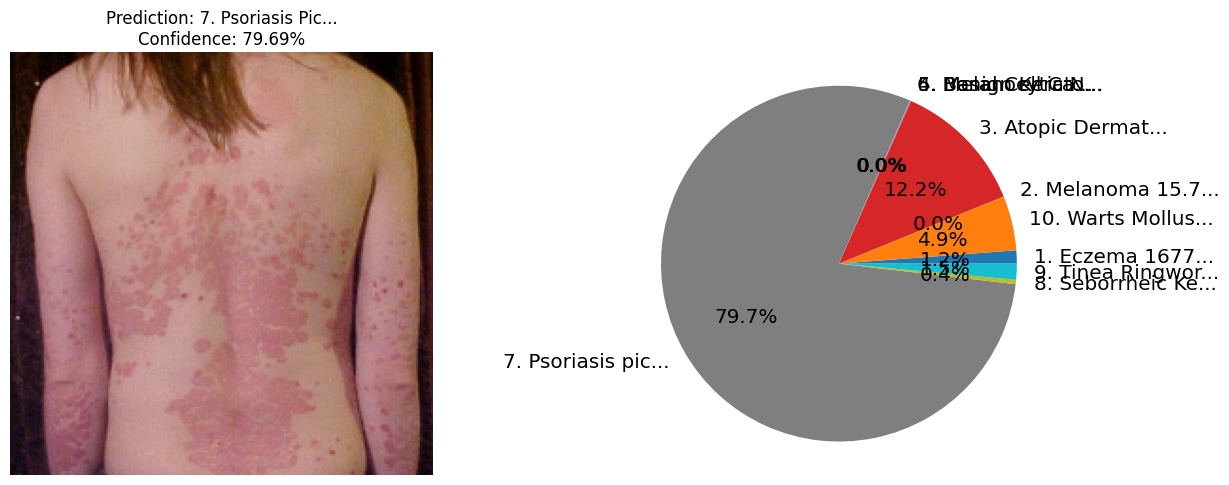

{'datetime': 1695686305881,
 'consumed_time': 1288,
 'prediction': '7. Psoriasis pictures Lichen Planus and related diseases - 2k',
 'confidence': 79.69}

In [40]:
predict_network_img(efficientnet_b7_model, class_names, "https://upload.wikimedia.org/wikipedia/commons/f/f5/Psoriasis_on_back1.jpg")

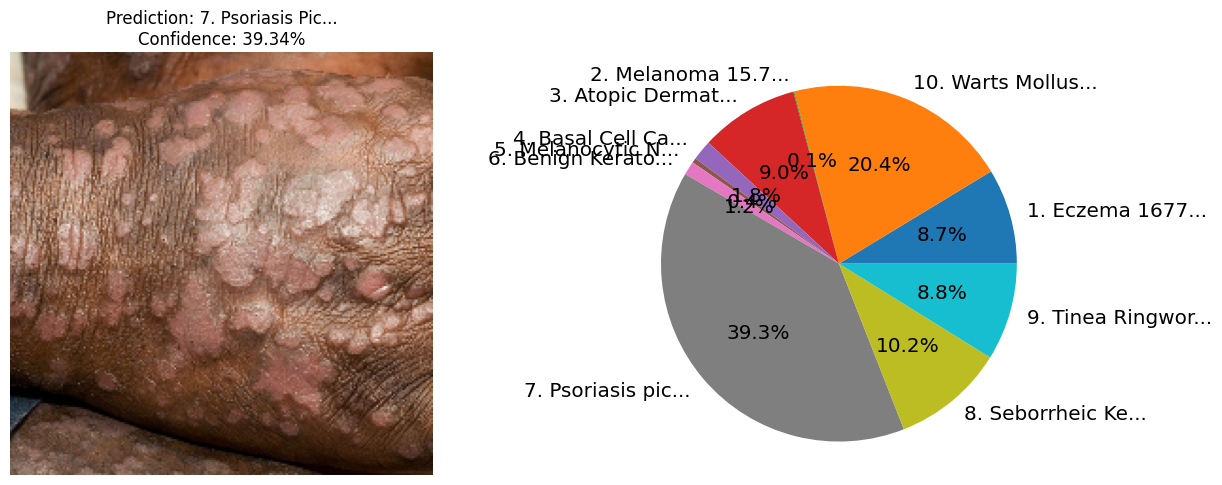

{'datetime': 1695686307294,
 'consumed_time': 1198,
 'prediction': '7. Psoriasis pictures Lichen Planus and related diseases - 2k',
 'confidence': 39.34}

In [41]:
predict_network_img(efficientnet_b7_model, class_names, "https://post.healthline.com/wp-content/uploads/2022/04/Guttate-psoriasis-on-black-skin-1296x728-slide3.jpg")

## Create Endpoint

### FastAPI application

In [32]:
!pip install fastapi
!pip install python-multipart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.6 MB/s eta 0:00:00


In [33]:
from fastapi import FastAPI, File, UploadFile
import pickle

app = FastAPI()

# FOR LATER
# @app.on_event("startup")
# def load_model():
#     global model
#     model = pickle.load(open("model_tree.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}


@app.post('/predict')
async def get_music_category(file: UploadFile = File(...)):
    results = predict_img_bytes(efficientnet_b7_model, class_names, await file.read())
    return results


### ColabCode Server

In [ ]:
!pip install colabcode

In [35]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

Public URL: NgrokTunnel: "https://d200-34-30-91-154.ngrok.io" -> "http://localhost:10000"


INFO:     Started server process [1695]
INFO:uvicorn.error:Started server process [1695]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)


INFO:     115.244.41.200:0 - "GET / HTTP/1.1" 200 OK
INFO:     115.244.41.200:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


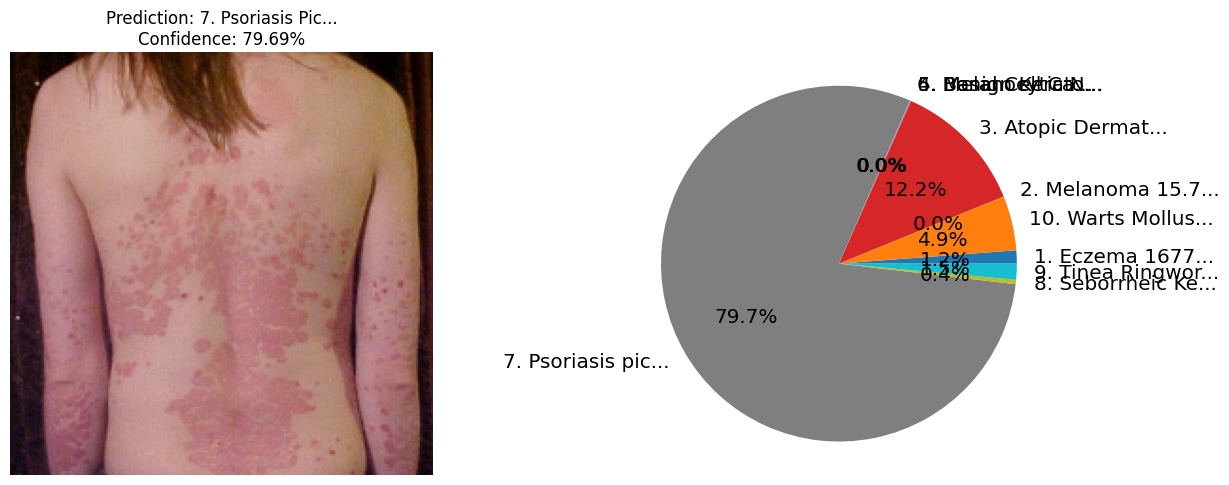

INFO:     115.244.41.200:0 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:uvicorn.error:Shutting down
INFO:     Waiting for application shutdown.
INFO:uvicorn.error:Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:uvicorn.error:Application shutdown complete.
INFO:     Finished server process [1695]
INFO:uvicorn.error:Finished server process [1695]


In [42]:
server.run_app(app=app)